In [63]:
#import all required packages
import pandas as pd
import numpy as np
import os
import json
from sqlalchemy import *
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
import math
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Connect pgadmin

In [64]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

In [65]:
db, conn = pgconnect(credentials)

Connected successfully.


# Establish srid

In [66]:
srid = 4283

def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

# Task 1

# Read data and clean data

In [67]:
BS_data = pd.read_csv('BusinessStats.csv')

n_data = pd.read_csv('Neighbourhoods.csv')
n_data = n_data.drop(columns = 'Unnamed: 0')
n_data = n_data.dropna()
n_data.rename(columns = {'0-4': 'young_one','5-9': 'young_two','10-14': 'young_three','15-19': 'young_four'}, inplace = True)
n_data['young'] = n_data['young_one'] + n_data['young_two'] + n_data['young_three'] + n_data['young_four']
n_data['population'] = n_data['population'].str.replace(',', '').astype(float)
n_data['number_of_dwellings'] = n_data['number_of_dwellings'].str.replace(',', '').astype(float)
n_data['per_people'] = n_data['population']/1000
n_data['per_young'] = n_data['young']/1000


data_path = "./school_catchments"
CP_data = gpd.read_file( os.path.join(data_path, "catchments_primary.shp") )
CS_data = gpd.read_file( os.path.join(data_path, "catchments_secondary.shp") )
CF_data = gpd.read_file( os.path.join(data_path, "catchments_future.shp") )

data_path = "./break_and_enter"
BE_data = gpd.read_file( os.path.join(data_path, "BreakEnterDwelling_JanToDec2021.shp") )

data_path = "./SA2_2016_AUST"
SA_data = gpd.read_file( os.path.join(data_path, "SA2_2016_AUST.shp") )
SA_data = SA_data[SA_data['GCC_NAME16'] == 'Greater Sydney']

# Pass data into pgadmin

## neighbourhoods

In [102]:
conn.execute("DROP TABLE IF EXISTS neighbourhoods")

n_schema = """CREATE TABLE IF NOT EXISTS neighbourhoods (
                         area_id                        INTEGER,
                         area_name                      TEXT,
                         land_area                      INTEGER,
                         population                     INTEGER, 
                         number_of_dwellings            INTEGER, 
                         number_of_businesses           INTEGER,
                         median_annual_household_income INTEGER,
                         avg_monthly_rent               INTEGER, 
                         young_one                      INTEGER,
                         young_two                      INTEGER,
                         young_three                    INTEGER,
                         young_four                     INTEGER,
                         young                          INTEGER,
                         per_people                     INTEGER,
                         per_young                      INTEGER
                         
                   )"""

conn.execute(n_schema)

table_name = "neighbourhoods"
n_data.to_sql(table_name, con=conn, if_exists='replace', index=False)

test_n = pd.read_sql_query('SELECT * FROM "neighbourhoods"', conn)
test_n

,area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,young_four,young,per_people,per_young,geom
0,102011028,Avoca Beach - Copacabana,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,560,2214,7.590,2.214,"MULTIPOLYGON(((151.41372757 -33.4655932489999,..."
1,102011029,Box Head - MacMasters Beach,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,692,2635,10.986,2.635,"MULTIPOLYGON(((151.353983677 -33.498540103,151..."
2,102011030,Calga - Kulnura,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,320,1098,4.841,1.098,MULTIPOLYGON(((151.204595054 -33.5329829959999...
3,102011031,Erina - Green Point,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,838,3227,14.237,3.227,"MULTIPOLYGON(((151.367948322 -33.438224164,151..."
4,102011032,Gosford - Springfield,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,977,4219,19.385,4.219,MULTIPOLYGON(((151.310060818 -33.4269890959999...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,22084.0,5931.0,1591.0,55391.0,1947.0,1575,1819,1506,1310,6210,22.084,6.210,"MULTIPOLYGON(((151.069051062 -33.998175005,151..."
305,128021538,Sutherland - Kirrawee,21760.0,6924.0,2086.0,53378.0,1809.0,1538,1242,1081,1033,4894,21.760,4.894,"MULTIPOLYGON(((151.05049439 -34.0200584319999,..."
306,128021607,Engadine,17424.0,5219.0,1121.0,52667.0,1955.0,1333,1529,1283,1031,5176,17.424,5.176,MULTIPOLYGON(((150.995678032 -34.0536210029999...
307,128021608,Loftus - Yarrawarrah,7426.0,2177.0,417.0,51243.0,2163.0,503,572,532,447,2054,7.426,2.054,MULTIPOLYGON(((151.039542783 -34.0417579149999...


## businessstats

In [69]:
conn.execute("DROP TABLE IF EXISTS businessstats")

BS_schema = """CREATE TABLE IF NOT EXISTS businessstats (
                         area_id                           INTEGER PRIMARY KEY,
                         area_name                         TEXT,
                         number_of_businesses              INTEGER,
                         accommodation_and_food_services   INTEGER, 
                         retail_trade                      INTEGER, 
                         agriculture_forestry_and_fishing  INTEGER,
                         health_care_and_social_assistance INTEGER,
                         public_administration_and_safety  INTEGER,
                         transport_postal_and_warehousing  INTEGER
                   )"""

conn.execute(BS_schema)

table_name = "businessstats"
BS_data.to_sql(table_name, con=conn, if_exists='replace', index=False)

test_bs = pd.read_sql_query('SELECT * FROM "businessstats"', conn)
test_bs

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


## catchments

#### catchments_primary

In [70]:
conn.execute("DROP TABLE IF EXISTS Public.catchments_primary;")

CP_schema = """CREATE TABLE IF NOT EXISTS catchments_primary (
                              use_id     INTEGER PRIMARY KEY,
                              catch_type TEXT, 
                              use_desc   TEXT, 
                              add_date   INTEGER, 
                              kindergart CHAR(1), 
                              year1      CHAR(1), 
                              year2      CHAR(1), 
                              year3      CHAR(1), 
                              year4      CHAR(1), 
                              year5      CHAR(1), 
                              year6      CHAR(1), 
                              year7      CHAR(1), 
                              year8      CHAR(1), 
                              year9      CHAR(1), 
                              year10     CHAR(1), 
                              year11     CHAR(1), 
                              year12     CHAR(1), 
                              priority   TEXT,
                              geom       GEOMETRY(MULTIPOLYGON, 4283))"""

conn.execute(CP_schema)

CP_copy = CP_data.copy()
CP_copy.columns = CP_copy.columns.map(lambda x:x. lower())
CP_copy['geom'] = CP_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
CP_copy = CP_copy.drop(columns="geometry")

table_name = 'catchments_primary'
CP_copy.to_sql(table_name, conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

test1 = pd.read_sql_query('SELECT * FROM "catchments_primary"', conn)
test1

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,2838,PRIMARY,Parklea PS,20181210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000078...
1,3943,PRIMARY,Gordon WPS,20211219.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB100000010000000103000000010000006F...
2,2404,PRIMARY,Lindfield EPS,20211219.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000BE...
3,1839,PRIMARY,Empire Bay PS,20211115.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000032...
4,4393,PRIMARY,Carlingford WPS,20220223.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000065...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,2409,PRIMARY,Lismore SPS,20200616.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000C9...
1662,4383,PRIMARY,E A Southee PS,20200315.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000B9...
1663,3275,PRIMARY,Tumbarumba PS,20200507.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000C0...
1664,2239,PRIMARY,Jindera PS,20200507.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000F6...


#### catchments_secondary

In [71]:
conn.execute("DROP TABLE IF EXISTS catchments_secondary")

CS_schema = """CREATE TABLE IF NOT EXISTS catchments_secondary (
                              use_id     INTEGER PRIMARY KEY,
                              catch_type TEXT, 
                              use_desc   TEXT, 
                              add_date   INTEGER, 
                              kindergart CHAR(1), 
                              year1      CHAR(1), 
                              year2      CHAR(1), 
                              year3      CHAR(1), 
                              year4      CHAR(1), 
                              year5      CHAR(1), 
                              year6      CHAR(1), 
                              year7      CHAR(1), 
                              year8      CHAR(1), 
                              year9      CHAR(1), 
                              year10     CHAR(1), 
                              year11     CHAR(1), 
                              year12     CHAR(1), 
                              priority   TEXT,
                              geom       GEOMETRY(MULTIPOLYGON, 4283)
                              )"""

conn.execute(CS_schema)

CS_copy = CS_data.copy()
CS_copy.columns = CS_copy.columns.map(lambda x:x. lower())
CS_copy['geom'] = CS_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
CS_copy = CS_copy.drop(columns="geometry")

table_name = 'catchments_secondary'
CS_copy.to_sql(table_name, conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

test2 = pd.read_sql_query('SELECT * FROM "catchments_secondary"', conn)
test2

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,8503,HIGH_COED,Billabong HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB100000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB1000000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,20201016.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB100000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,20211115.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB100000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB100000010000000103000000010000003F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,8213,HIGH_BOYS,Birrong BHS,20211221.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB1000000100000001030000000100000040...
431,8857,HIGH_GIRLS,GRC Penshurst Girls,20220110.0,N,N,N,N,N,N,N,Y,Y,Y,Y,N,N,None,0106000020BB10000001000000010300000001000000A1...
432,3235,CENTRAL_HIGH,Tooleybuc CS,20200512.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB100000010000000103000000010000003E...
433,1115,CENTRAL_HIGH,Balranald CS,20200512.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB100000010000000103000000010000005B...


#### catchments_future

In [72]:
conn.execute("DROP TABLE IF EXISTS catchments_future")

CF_schema = """CREATE TABLE IF NOT EXISTS catchments_future (
                              use_id     INTEGER PRIMARY KEY,
                              catch_type TEXT, 
                              use_desc   TEXT, 
                              add_date   INTEGER, 
                              kindergart TEXT, 
                              year1      TEXT, 
                              year2      TEXT, 
                              year3      TEXT, 
                              year4      TEXT, 
                              year5      TEXT, 
                              year6      TEXT, 
                              year7      TEXT, 
                              year8      TEXT, 
                              year9      TEXT, 
                              year10     TEXT, 
                              year11     TEXT, 
                              year12     TEXT, 
                              priority   TEXT,
                              geom       GEOMETRY(MULTIPOLYGON, 4283)
                              )""" 

conn.execute(CF_schema)

CF_copy = CF_data.copy()
CF_copy.columns = CF_copy.columns.map(lambda x:x. lower())
CF_copy['geom'] = CF_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
CF_copy = CF_copy.drop(columns="geometry")

table_name = 'catchments_future'
CF_copy.to_sql(table_name, conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

test3 = pd.read_sql_query('SELECT * FROM "catchments_future"', conn)
test3

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,2133,PRIMARY,Harbord PS,20200720,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020BB1000000100000001030000000100000084...
1,4021,PRIMARY,Manly Vale PS,20200805,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020BB100000010000000103000000010000009D...
2,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,0106000020BB100000010000000103000000010000006F...
3,2469,PRIMARY,Manly WPS,20200805,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020BB1000000100000001030000000100000060...
4,4450,PRIMARY,Berinba PS,20220110,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020BB10000001000000010300000001000000AF...
5,4683,PRIMARY,Murrumbateman PS,20220110,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020BB100000010000000103000000010000008E...
6,8463,HIGH_COED,Sylvania HS,20210217,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,0106000020BB100000010000000103000000010000001E...
7,8404,HIGH_COED,Endeavour Sp HS,20210217,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,0106000020BB100000010000000103000000010000008F...
8,3827,PRIMARY,Narraweena PS,20200720,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020BB1000000100000001030000000100000091...
9,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,0106000020BB100000010000000103000000010000000C...


## breakandenter

In [73]:
conn.execute("DROP TABLE IF EXISTS breakandenter")

BE_schema = """CREATE TABLE IF NOT EXISTS breakandenter (
                              objectid   INTEGER PRIMARY KEY,
                              contour    FLOAT, 
                              density    TEXT, 
                              orig_fid   INTEGER, 
                              shape_leng FLOAT, 
                              shape_area FLOAT, 
                              geom       GEOMETRY(MULTIPOLYGON, 4283)
                              )"""

conn.execute(BE_schema)

BE_copy = BE_data.copy()
BE_copy.columns = BE_copy.columns.map(lambda x:x. lower())
BE_copy['geom'] = BE_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
BE_copy = BE_copy.drop(columns="geometry")

BE_copy.to_sql('breakandenter', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

test_be = pd.read_sql_query('SELECT * FROM "breakandenter"', conn)
test_be

,objectid,contour,density,orig_fid,shape_leng,shape_area,geom
0,1,8.0,Low Density,1,0.012138,0.000006,0106000020BB1000000100000001030000000100000015...
1,2,8.0,Low Density,1,0.019106,0.000015,0106000020BB100000010000000103000000010000001D...
2,3,8.0,Low Density,1,0.006068,0.000002,0106000020BB1000000100000001030000000100000007...
3,4,8.0,Low Density,1,0.011006,0.000006,0106000020BB100000010000000103000000010000000E...
4,5,8.0,Low Density,1,0.008073,0.000003,0106000020BB100000010000000103000000010000000F...
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,0.015358,0.000011,0106000020BB1000000100000001030000000100000016...
2590,2591,10.0,High Density,3,0.028327,0.000029,0106000020BB1000000100000001030000000100000028...
2591,2592,10.0,High Density,3,0.006654,0.000002,0106000020BB1000000100000001030000000100000009...
2592,2593,10.0,High Density,3,0.047098,0.000044,0106000020BB100000010000000103000000010000004D...


## sa2_shape_data

In [74]:
conn.execute("DROP TABLE IF EXISTS sa2_shape_data")

SA_shcema = """CREATE TABLE IF NOT EXISTS sa2_shape_data (
                              sa2_main16 INTEGER, 
                              sa2_5dig16 INTEGER, 
                              sa2_name16 TEXT, 
                              sa3_code16 INTEGER, 
                              sa3_name16 TEXT, 
                              sa4_code16 INTEGER, 
                              sa4_name16 TEXT, 
                              gcc_code16 TEXT, 
                              gcc_name16 TEXT, 
                              ste_code16 INTEGER, 
                              ste_name16 TEXT, 
                              areasqkm16 INTEGER, 
                              geom       GEOMETRY(MULTIPOLYGON,4283)
                              )"""

conn.execute(SA_shcema)

SA_copy = SA_data.copy()
SA_copy.columns = SA_copy.columns.map(lambda x:x. lower())
SA_copy['geom'] = SA_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
SA_copy = SA_copy.drop(columns="geometry")

SA_copy.to_sql('sa2_shape_data', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

test_sa = pd.read_sql_query('SELECT * FROM "sa2_shape_data"', conn)
test_sa

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,gcc_code16,gcc_name16,ste_code16,ste_name16,areasqkm16,geom
0,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6,0106000020BB100000010000000103000000010000005E...
1,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32,0106000020BB1000000100000001030000000100000000...
2,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,768,0106000020BB1000000200000001030000000100000085...
3,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,34,0106000020BB1000000100000001030000000100000041...
4,102011032,11032,Gosford - Springfield,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,17,0106000020BB100000010000000103000000010000007F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,128021537,11537,Royal National Park,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,139,0106000020BB1000000100000001030000000100000047...
308,128021538,11538,Sutherland - Kirrawee,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8,0106000020BB1000000100000001030000000100000089...
309,128021607,11607,Engadine,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,9,0106000020BB100000010000000103000000010000008E...
310,128021608,11608,Loftus - Yarrawarrah,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,4,0106000020BB10000001000000010300000001000000A1...


## At least 1 extra dataset for the City of Sydney Analysis(it will be in task3)

# Task 2

## Combine the three schools

Three different catchments need to be merged, and all three types of catchments must have the same number of columns.

In [75]:
CF_data.insert(17,'priority',None) 

CF_data

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,priority,geometry
0,2133,PRIMARY,Harbord PS,20200720,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,"POLYGON ((151.29769 -33.76832, 151.29731 -33.7..."
1,4450,PRIMARY,Berinba PS,20220110,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,"POLYGON ((149.10301 -34.82127, 149.10167 -34.8..."
2,4683,PRIMARY,Murrumbateman PS,20220110,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,"POLYGON ((149.10557 -34.89523, 149.11035 -34.8..."
3,4021,PRIMARY,Manly Vale PS,20200805,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,"POLYGON ((151.27162 -33.76913, 151.27116 -33.7..."
4,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
5,2469,PRIMARY,Manly WPS,20200805,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,"POLYGON ((151.28453 -33.78790, 151.28559 -33.7..."
6,8463,HIGH_COED,Sylvania HS,20210217,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,"POLYGON ((151.14827 -33.99111, 151.14859 -33.9..."
7,8404,HIGH_COED,Endeavour Sp HS,20210217,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,"POLYGON ((151.12719 -34.01025, 151.12706 -34.0..."
8,3827,PRIMARY,Narraweena PS,20200720,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,"POLYGON ((151.26725 -33.74242, 151.26789 -33.7..."
9,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


Combine three catchments

In [76]:
school_catchments = """SELECT *
FROM public."catchments_future" 
union all SELECT * FROM public."catchments_secondary" 
union all SELECT * FROM public."catchments_primary"
order by use_id;"""

school_catchments = pd.read_sql_query(school_catchments, conn)

school_catchments

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,1001,PRIMARY,Abbotsford PS,20160825.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000A5...
1,1002,PRIMARY,Aberdeen PS,20191210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000B6...
2,1003,PRIMARY,Abermain PS,20191217.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB100000010000000103000000010000000B...
3,1007,PRIMARY,Adaminaby PS,20210610.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000C5...
4,1008,PRIMARY,Adamstown PS,20210814.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB100000010000000103000000010000002F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,8916,HIGH_COED,Oran Park HS,20200310.0,N,N,N,N,N,N,N,Y,Y,Y,Y,N,N,N,0106000020BB100000010000000103000000010000008C...
2141,8916,HIGH_COED,Oran Park HS,20190520.0,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2024,None,0106000020BB1000000100000001030000000100000086...
2142,8917,HIGH_COED,Murrumbidgee RHS,20200527.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB100000020000000103000000010000001A...
2143,8919,HIGH_COED,Bungendore HS,20220305.0,0,0,0,0,0,0,0,2023,2023,0,0,0,0,None,0106000020BB10000001000000010300000001000000D7...


Pass the merged data into pgadmin

In [77]:
conn.execute("DROP TABLE IF EXISTS school_catchments")

school_catchments_schema = """CREATE TABLE IF NOT EXISTS school_catchments (
                              use_id     TEXT,
                              catch_type TEXT, 
                              use_desc   TEXT, 
                              add_date   INTEGER, 
                              kindergart VARCHAR(4), 
                              year1      VARCHAR(4), 
                              year2      VARCHAR(4), 
                              year3      VARCHAR(4), 
                              year4      VARCHAR(4), 
                              year5      VARCHAR(4), 
                              year6      VARCHAR(4), 
                              year7      VARCHAR(4), 
                              year8      VARCHAR(4), 
                              year9      VARCHAR(4), 
                              year10     VARCHAR(4), 
                              year11     VARCHAR(4), 
                              year12     VARCHAR(4), 
                              priority   TEXT,
                              geom       GEOMETRY(MULTIPOLYGON, 4283)

)""" 

conn.execute(school_catchments_schema)

school_catchments.to_sql('school_catchments', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

test_22 = pd.read_sql_query('SELECT * FROM "school_catchments"', conn)
test_22

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,1001,PRIMARY,Abbotsford PS,20160825.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000A5...
1,1002,PRIMARY,Aberdeen PS,20191210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000B6...
2,3141,PRIMARY,Swansea PS,20211117.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB100000010000000103000000010000002A...
3,3143,PRIMARY,Sylvania PS,NaN,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000FB...
4,3145,PRIMARY,Tabulam PS,20200616.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000AE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,8910,HIGH_COED,Cammeraygal HS,20211219.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB1000000100000001030000000100000008...
2141,8911,HIGH_COED,The Ponds HS,20191210.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020BB100000010000000103000000010000006E...
2142,8913,HIGH_COED,Inner Sydney HS,20200220.0,0,0,0,0,0,0,0,2023,2023,2023,2023,2024,2025,None,0106000020BB1000000100000001030000000100000076...
2143,8913,HIGH_COED,Inner Sydney HS,20200220.0,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Y,0106000020BB1000000100000001030000000100000076...


## To facilitate analysis

Add geom to neighbourhoods

In [104]:
conn.execute('''ALTER TABLE "neighbourhoods" ADD COLUMN geom geometry(MULTIPOLYGON, 4283)''') 
conn.execute('''UPDATE "neighbourhoods" as N 
                    SET geom = (
                        SELECT geom 
                          FROM sa2_shape_data
                         WHERE sa2_shape_data.sa2_main16 = N.area_id
                    );''') 
n_data = pd.read_sql_query('''SELECT area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,young_four,young,per_people,per_young,n.geom as geom 
FROM public."neighbourhoods" n''', conn)
n_data

,area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,young_four,young,per_people,per_young,geom
0,102011028,Avoca Beach - Copacabana,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,560,2214,7.590,2.214,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,692,2635,10.986,2.635,0106000020BB1000000100000001030000000100000000...
2,102011030,Calga - Kulnura,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,320,1098,4.841,1.098,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,838,3227,14.237,3.227,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,977,4219,19.385,4.219,0106000020BB100000010000000103000000010000007F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,22084.0,5931.0,1591.0,55391.0,1947.0,1575,1819,1506,1310,6210,22.084,6.210,0106000020BB10000001000000010300000001000000EF...
305,128021538,Sutherland - Kirrawee,21760.0,6924.0,2086.0,53378.0,1809.0,1538,1242,1081,1033,4894,21.760,4.894,0106000020BB1000000100000001030000000100000089...
306,128021607,Engadine,17424.0,5219.0,1121.0,52667.0,1955.0,1333,1529,1283,1031,5176,17.424,5.176,0106000020BB100000010000000103000000010000008E...
307,128021608,Loftus - Yarrawarrah,7426.0,2177.0,417.0,51243.0,2163.0,503,572,532,447,2054,7.426,2.054,0106000020BB10000001000000010300000001000000A1...


# score

## z-school:

In [105]:
school = pd.read_sql_query("""select area_id,sum(ST_Area(S.geom::geography)/per_young) as school
from "neighbourhoods" N join "school_catchments" S on ST_contains(N.geom,S.geom) 
group by area_id
ORDER BY area_id;
""", conn)
score = pd.merge(n_data,school,how='left',on = 'area_id')
score['school'].fillna(0,inplace= True)
school_mean = score['school'].mean()
school_std = score['school'].std()
for index,row in score.iterrows():
    score.at[index,'z_school'] = (row['school']-school_mean) /school_std
score = score.drop(columns='school')
score

,area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,young_four,young,per_people,per_young,geom,z_school
0,102011028,Avoca Beach - Copacabana,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,560,2214,7.590,2.214,0106000020BB100000010000000103000000010000005E...,-0.072051
1,102011029,Box Head - MacMasters Beach,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,692,2635,10.986,2.635,0106000020BB1000000100000001030000000100000000...,-0.072051
2,102011030,Calga - Kulnura,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,320,1098,4.841,1.098,0106000020BB1000000200000001030000000100000085...,17.348172
3,102011031,Erina - Green Point,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,838,3227,14.237,3.227,0106000020BB1000000100000001030000000100000041...,-0.072051
4,102011032,Gosford - Springfield,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,977,4219,19.385,4.219,0106000020BB100000010000000103000000010000007F...,-0.072051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,22084.0,5931.0,1591.0,55391.0,1947.0,1575,1819,1506,1310,6210,22.084,6.210,0106000020BB10000001000000010300000001000000EF...,-0.072051
305,128021538,Sutherland - Kirrawee,21760.0,6924.0,2086.0,53378.0,1809.0,1538,1242,1081,1033,4894,21.760,4.894,0106000020BB1000000100000001030000000100000089...,0.071367
306,128021607,Engadine,17424.0,5219.0,1121.0,52667.0,1955.0,1333,1529,1283,1031,5176,17.424,5.176,0106000020BB100000010000000103000000010000008E...,-0.072051
307,128021608,Loftus - Yarrawarrah,7426.0,2177.0,417.0,51243.0,2163.0,503,572,532,447,2054,7.426,2.054,0106000020BB10000001000000010300000001000000A1...,-0.072051


## z-accom

In [106]:
accom = pd.read_sql_query("""select N.area_id,accommodation_and_food_services/per_people as accom
from "businessstats" B join "neighbourhoods" N on (N.area_name = B.area_name)
""",conn)
score2= pd.merge(score,accom,how='left',on = 'area_id')
score2['accom'].fillna(0,inplace= True)
accom_mean = score2['accom'].mean()
accom_std = score2['accom'].std()
for index,row in score2.iterrows():
    score2.at[index,'z_accom'] = (row['accom']-accom_mean) /accom_std
score2 = score2.drop(columns='accom')
score2

,area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,young_four,young,per_people,per_young,geom,z_school,z_accom
0,102011028,Avoca Beach - Copacabana,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,560,2214,7.590,2.214,0106000020BB100000010000000103000000010000005E...,-0.072051,0.140544
1,102011029,Box Head - MacMasters Beach,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,692,2635,10.986,2.635,0106000020BB1000000100000001030000000100000000...,-0.072051,-0.472598
2,102011030,Calga - Kulnura,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,320,1098,4.841,1.098,0106000020BB1000000200000001030000000100000085...,17.348172,-0.255441
3,102011031,Erina - Green Point,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,838,3227,14.237,3.227,0106000020BB1000000100000001030000000100000041...,-0.072051,0.257083
4,102011032,Gosford - Springfield,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,977,4219,19.385,4.219,0106000020BB100000010000000103000000010000007F...,-0.072051,0.276890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,22084.0,5931.0,1591.0,55391.0,1947.0,1575,1819,1506,1310,6210,22.084,6.210,0106000020BB10000001000000010300000001000000EF...,-0.072051,-0.401588
305,128021538,Sutherland - Kirrawee,21760.0,6924.0,2086.0,53378.0,1809.0,1538,1242,1081,1033,4894,21.760,4.894,0106000020BB1000000100000001030000000100000089...,0.071367,-0.129558
306,128021607,Engadine,17424.0,5219.0,1121.0,52667.0,1955.0,1333,1529,1283,1031,5176,17.424,5.176,0106000020BB100000010000000103000000010000008E...,-0.072051,-0.464456
307,128021608,Loftus - Yarrawarrah,7426.0,2177.0,417.0,51243.0,2163.0,503,572,532,447,2054,7.426,2.054,0106000020BB10000001000000010300000001000000A1...,-0.072051,-0.712391


## z-retail

In [107]:
retail =  pd.read_sql_query("""select N.area_id,B.retail_trade/N.per_people as retail
from "businessstats" B join "neighbourhoods" N on (N.area_name = B.area_name)
""",conn)
score3 = pd.merge(score2,retail,how='left',on = 'area_id')
score3['retail'].fillna(0,inplace= True)
retail_mean = score3['retail'].mean()
retail_std = score3['retail'].std()
for index,row in score3.iterrows():
    score3.at[index,'z_retail'] = (row['retail']-retail_mean) /retail_std
score3 = score3.drop(columns='retail')
score3

,area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,young_four,young,per_people,per_young,geom,z_school,z_accom,z_retail
0,102011028,Avoca Beach - Copacabana,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,560,2214,7.590,2.214,0106000020BB100000010000000103000000010000005E...,-0.072051,0.140544,-0.263253
1,102011029,Box Head - MacMasters Beach,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,692,2635,10.986,2.635,0106000020BB1000000100000001030000000100000000...,-0.072051,-0.472598,-0.361426
2,102011030,Calga - Kulnura,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,320,1098,4.841,1.098,0106000020BB1000000200000001030000000100000085...,17.348172,-0.255441,0.550609
3,102011031,Erina - Green Point,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,838,3227,14.237,3.227,0106000020BB1000000100000001030000000100000041...,-0.072051,0.257083,0.798755
4,102011032,Gosford - Springfield,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,977,4219,19.385,4.219,0106000020BB100000010000000103000000010000007F...,-0.072051,0.276890,0.499627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,22084.0,5931.0,1591.0,55391.0,1947.0,1575,1819,1506,1310,6210,22.084,6.210,0106000020BB10000001000000010300000001000000EF...,-0.072051,-0.401588,-0.417154
305,128021538,Sutherland - Kirrawee,21760.0,6924.0,2086.0,53378.0,1809.0,1538,1242,1081,1033,4894,21.760,4.894,0106000020BB1000000100000001030000000100000089...,0.071367,-0.129558,-0.152413
306,128021607,Engadine,17424.0,5219.0,1121.0,52667.0,1955.0,1333,1529,1283,1031,5176,17.424,5.176,0106000020BB100000010000000103000000010000008E...,-0.072051,-0.464456,-0.387353
307,128021608,Loftus - Yarrawarrah,7426.0,2177.0,417.0,51243.0,2163.0,503,572,532,447,2054,7.426,2.054,0106000020BB10000001000000010300000001000000A1...,-0.072051,-0.712391,-0.628744


## z-crime

#### Analysis in three different densities

#### calulate low density

In [108]:
low = pd.read_sql_query("""select area_id,sum(ST_Area(B.geom::geography)/ST_Area(N.geom::geography)) as low_area
from "neighbourhoods" N join "breakandenter" B on ST_Intersects(N.geom,B.geom)
where B.Density = 'Low Density'
group by area_id;""",conn)

score4= pd.merge(score3,low,how='left',on = 'area_id')       
score4['low_area'].fillna(0,inplace= True)
low_mean = score4['low_area'].mean()
low_std = score4['low_area'].std()
for index,row in score4.iterrows():
    score4.at[index,'low_area'] = (row['low_area']-low_mean) /low_std

score4

,area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,young_four,young,per_people,per_young,geom,z_school,z_accom,z_retail,low_area
0,102011028,Avoca Beach - Copacabana,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,560,2214,7.590,2.214,0106000020BB100000010000000103000000010000005E...,-0.072051,0.140544,-0.263253,-0.520317
1,102011029,Box Head - MacMasters Beach,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,692,2635,10.986,2.635,0106000020BB1000000100000001030000000100000000...,-0.072051,-0.472598,-0.361426,-0.517993
2,102011030,Calga - Kulnura,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,320,1098,4.841,1.098,0106000020BB1000000200000001030000000100000085...,17.348172,-0.255441,0.550609,-0.520317
3,102011031,Erina - Green Point,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,838,3227,14.237,3.227,0106000020BB1000000100000001030000000100000041...,-0.072051,0.257083,0.798755,-0.518280
4,102011032,Gosford - Springfield,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,977,4219,19.385,4.219,0106000020BB100000010000000103000000010000007F...,-0.072051,0.276890,0.499627,-0.451475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,22084.0,5931.0,1591.0,55391.0,1947.0,1575,1819,1506,1310,6210,22.084,6.210,0106000020BB10000001000000010300000001000000EF...,-0.072051,-0.401588,-0.417154,-0.508726
305,128021538,Sutherland - Kirrawee,21760.0,6924.0,2086.0,53378.0,1809.0,1538,1242,1081,1033,4894,21.760,4.894,0106000020BB1000000100000001030000000100000089...,0.071367,-0.129558,-0.152413,-0.462514
306,128021607,Engadine,17424.0,5219.0,1121.0,52667.0,1955.0,1333,1529,1283,1031,5176,17.424,5.176,0106000020BB100000010000000103000000010000008E...,-0.072051,-0.464456,-0.387353,-0.504661
307,128021608,Loftus - Yarrawarrah,7426.0,2177.0,417.0,51243.0,2163.0,503,572,532,447,2054,7.426,2.054,0106000020BB10000001000000010300000001000000A1...,-0.072051,-0.712391,-0.628744,-0.520317


#### calculate the medium density

In [109]:
medium= pd.read_sql_query("""select area_id,sum(ST_Area(b.geom::geography)/ST_Area(n.geom::geography)) as medium_area
from "neighbourhoods" n join "breakandenter" b on ST_Intersects(n.geom,b.geom)
where b.Density = 'Medium Density'
group by area_id
""",conn)
score5= pd.merge(score4,medium,how='left',on = 'area_id')
score5['medium_area'].fillna(0,inplace= True)
medium_mean = score5['medium_area'].mean()
medium_std = score5['medium_area'].std()
for index,row in score5.iterrows():
    score5.at[index,'medium_area'] = (row['medium_area']-medium_mean) /medium_std

score5

,area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,young_four,young,per_people,per_young,geom,z_school,z_accom,z_retail,low_area,medium_area
0,102011028,Avoca Beach - Copacabana,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,560,2214,7.590,2.214,0106000020BB100000010000000103000000010000005E...,-0.072051,0.140544,-0.263253,-0.520317,-0.407729
1,102011029,Box Head - MacMasters Beach,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,692,2635,10.986,2.635,0106000020BB1000000100000001030000000100000000...,-0.072051,-0.472598,-0.361426,-0.517993,-0.406945
2,102011030,Calga - Kulnura,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,320,1098,4.841,1.098,0106000020BB1000000200000001030000000100000085...,17.348172,-0.255441,0.550609,-0.520317,-0.407729
3,102011031,Erina - Green Point,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,838,3227,14.237,3.227,0106000020BB1000000100000001030000000100000041...,-0.072051,0.257083,0.798755,-0.518280,-0.407729
4,102011032,Gosford - Springfield,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,977,4219,19.385,4.219,0106000020BB100000010000000103000000010000007F...,-0.072051,0.276890,0.499627,-0.451475,-0.324150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,22084.0,5931.0,1591.0,55391.0,1947.0,1575,1819,1506,1310,6210,22.084,6.210,0106000020BB10000001000000010300000001000000EF...,-0.072051,-0.401588,-0.417154,-0.508726,-0.398767
305,128021538,Sutherland - Kirrawee,21760.0,6924.0,2086.0,53378.0,1809.0,1538,1242,1081,1033,4894,21.760,4.894,0106000020BB1000000100000001030000000100000089...,0.071367,-0.129558,-0.152413,-0.462514,-0.330607
306,128021607,Engadine,17424.0,5219.0,1121.0,52667.0,1955.0,1333,1529,1283,1031,5176,17.424,5.176,0106000020BB100000010000000103000000010000008E...,-0.072051,-0.464456,-0.387353,-0.504661,-0.400402
307,128021608,Loftus - Yarrawarrah,7426.0,2177.0,417.0,51243.0,2163.0,503,572,532,447,2054,7.426,2.054,0106000020BB10000001000000010300000001000000A1...,-0.072051,-0.712391,-0.628744,-0.520317,-0.407729


#### calculate the high density

In [110]:
high= pd.read_sql_query("""select area_id,sum(ST_Area(b.geom::geography)/ST_Area(n.geom::geography)) as high_area
from "neighbourhoods" n join "breakandenter" b on ST_Intersects(n.geom,b.geom)
where b.Density = 'High Density'
group by area_id
""",conn)
score6= pd.merge(score5,high,how='left',on = 'area_id')
score6['high_area'].fillna(0,inplace= True)
high_mean = score6['high_area'].mean()
high_std = score6['high_area'].std()
for index,row in score6.iterrows():
    score6.at[index,'high_area'] = (row['high_area']-high_mean) /high_std

score6

,area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,...,young,per_people,per_young,geom,z_school,z_accom,z_retail,low_area,medium_area,high_area
0,102011028,Avoca Beach - Copacabana,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,...,2214,7.590,2.214,0106000020BB100000010000000103000000010000005E...,-0.072051,0.140544,-0.263253,-0.520317,-0.407729,-0.299713
1,102011029,Box Head - MacMasters Beach,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,...,2635,10.986,2.635,0106000020BB1000000100000001030000000100000000...,-0.072051,-0.472598,-0.361426,-0.517993,-0.406945,-0.299713
2,102011030,Calga - Kulnura,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,...,1098,4.841,1.098,0106000020BB1000000200000001030000000100000085...,17.348172,-0.255441,0.550609,-0.520317,-0.407729,-0.299713
3,102011031,Erina - Green Point,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,...,3227,14.237,3.227,0106000020BB1000000100000001030000000100000041...,-0.072051,0.257083,0.798755,-0.518280,-0.407729,-0.299713
4,102011032,Gosford - Springfield,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,...,4219,19.385,4.219,0106000020BB100000010000000103000000010000007F...,-0.072051,0.276890,0.499627,-0.451475,-0.324150,-0.210202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,22084.0,5931.0,1591.0,55391.0,1947.0,1575,1819,1506,...,6210,22.084,6.210,0106000020BB10000001000000010300000001000000EF...,-0.072051,-0.401588,-0.417154,-0.508726,-0.398767,-0.299713
305,128021538,Sutherland - Kirrawee,21760.0,6924.0,2086.0,53378.0,1809.0,1538,1242,1081,...,4894,21.760,4.894,0106000020BB1000000100000001030000000100000089...,0.071367,-0.129558,-0.152413,-0.462514,-0.330607,-0.223860
306,128021607,Engadine,17424.0,5219.0,1121.0,52667.0,1955.0,1333,1529,1283,...,5176,17.424,5.176,0106000020BB100000010000000103000000010000008E...,-0.072051,-0.464456,-0.387353,-0.504661,-0.400402,-0.299713
307,128021608,Loftus - Yarrawarrah,7426.0,2177.0,417.0,51243.0,2163.0,503,572,532,...,2054,7.426,2.054,0106000020BB10000001000000010300000001000000A1...,-0.072051,-0.712391,-0.628744,-0.520317,-0.407729,-0.299713


#### Combine the three to get z-crime

In [111]:
score6['z_crime'] = score6['low_area'] +2*score6['medium_area']+3*score6['high_area']
score6

,area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,...,per_people,per_young,geom,z_school,z_accom,z_retail,low_area,medium_area,high_area,z_crime
0,102011028,Avoca Beach - Copacabana,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,...,7.590,2.214,0106000020BB100000010000000103000000010000005E...,-0.072051,0.140544,-0.263253,-0.520317,-0.407729,-0.299713,-2.234913
1,102011029,Box Head - MacMasters Beach,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,...,10.986,2.635,0106000020BB1000000100000001030000000100000000...,-0.072051,-0.472598,-0.361426,-0.517993,-0.406945,-0.299713,-2.231021
2,102011030,Calga - Kulnura,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,...,4.841,1.098,0106000020BB1000000200000001030000000100000085...,17.348172,-0.255441,0.550609,-0.520317,-0.407729,-0.299713,-2.234913
3,102011031,Erina - Green Point,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,...,14.237,3.227,0106000020BB1000000100000001030000000100000041...,-0.072051,0.257083,0.798755,-0.518280,-0.407729,-0.299713,-2.232876
4,102011032,Gosford - Springfield,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,...,19.385,4.219,0106000020BB100000010000000103000000010000007F...,-0.072051,0.276890,0.499627,-0.451475,-0.324150,-0.210202,-1.730382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,22084.0,5931.0,1591.0,55391.0,1947.0,1575,1819,1506,...,22.084,6.210,0106000020BB10000001000000010300000001000000EF...,-0.072051,-0.401588,-0.417154,-0.508726,-0.398767,-0.299713,-2.205398
305,128021538,Sutherland - Kirrawee,21760.0,6924.0,2086.0,53378.0,1809.0,1538,1242,1081,...,21.760,4.894,0106000020BB1000000100000001030000000100000089...,0.071367,-0.129558,-0.152413,-0.462514,-0.330607,-0.223860,-1.795309
306,128021607,Engadine,17424.0,5219.0,1121.0,52667.0,1955.0,1333,1529,1283,...,17.424,5.176,0106000020BB100000010000000103000000010000008E...,-0.072051,-0.464456,-0.387353,-0.504661,-0.400402,-0.299713,-2.204603
307,128021608,Loftus - Yarrawarrah,7426.0,2177.0,417.0,51243.0,2163.0,503,572,532,...,7.426,2.054,0106000020BB10000001000000010300000001000000A1...,-0.072051,-0.712391,-0.628744,-0.520317,-0.407729,-0.299713,-2.234913


## z-health

In [112]:
health =  pd.read_sql_query("""select n.area_id,b.health_care_and_social_assistance/n.per_people as health
from "businessstats" b join "neighbourhoods" n on (n.area_name =b.area_name)
""",conn)
score7= pd.merge(score6,health,how='left',on = 'area_id')
health_mean = score7['health'].mean()
health_std = score7['health'].std()
for index,row in score7.iterrows():
    score7.at[index,'z_health'] = (row['health']-health_mean) /health_std

score7 = score7.drop(columns = 'health')
score7

,area_id,area_name,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young_one,young_two,young_three,...,per_young,geom,z_school,z_accom,z_retail,low_area,medium_area,high_area,z_crime,z_health
0,102011028,Avoca Beach - Copacabana,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,...,2.214,0106000020BB100000010000000103000000010000005E...,-0.072051,0.140544,-0.263253,-0.520317,-0.407729,-0.299713,-2.234913,0.361358
1,102011029,Box Head - MacMasters Beach,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,...,2.635,0106000020BB1000000100000001030000000100000000...,-0.072051,-0.472598,-0.361426,-0.517993,-0.406945,-0.299713,-2.231021,-0.468103
2,102011030,Calga - Kulnura,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,...,1.098,0106000020BB1000000200000001030000000100000085...,17.348172,-0.255441,0.550609,-0.520317,-0.407729,-0.299713,-2.234913,-0.766389
3,102011031,Erina - Green Point,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,...,3.227,0106000020BB1000000100000001030000000100000041...,-0.072051,0.257083,0.798755,-0.518280,-0.407729,-0.299713,-2.232876,1.331450
4,102011032,Gosford - Springfield,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,...,4.219,0106000020BB100000010000000103000000010000007F...,-0.072051,0.276890,0.499627,-0.451475,-0.324150,-0.210202,-1.730382,1.355839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,22084.0,5931.0,1591.0,55391.0,1947.0,1575,1819,1506,...,6.210,0106000020BB10000001000000010300000001000000EF...,-0.072051,-0.401588,-0.417154,-0.508726,-0.398767,-0.299713,-2.205398,-0.415763
305,128021538,Sutherland - Kirrawee,21760.0,6924.0,2086.0,53378.0,1809.0,1538,1242,1081,...,4.894,0106000020BB1000000100000001030000000100000089...,0.071367,-0.129558,-0.152413,-0.462514,-0.330607,-0.223860,-1.795309,-0.068588
306,128021607,Engadine,17424.0,5219.0,1121.0,52667.0,1955.0,1333,1529,1283,...,5.176,0106000020BB100000010000000103000000010000008E...,-0.072051,-0.464456,-0.387353,-0.504661,-0.400402,-0.299713,-2.204603,-0.303486
307,128021608,Loftus - Yarrawarrah,7426.0,2177.0,417.0,51243.0,2163.0,503,572,532,...,2.054,0106000020BB10000001000000010300000001000000A1...,-0.072051,-0.712391,-0.628744,-0.520317,-0.407729,-0.299713,-2.234913,-0.581894


## Take out the column to be analyzed

In [113]:
score_final = score7[['area_id','area_name','geom','median_annual_household_income','avg_monthly_rent','z_school','z_accom','z_retail','z_crime','z_health']]
score_final

,area_id,area_name,geom,median_annual_household_income,avg_monthly_rent,z_school,z_accom,z_retail,z_crime,z_health
0,102011028,Avoca Beach - Copacabana,0106000020BB100000010000000103000000010000005E...,46996.0,1906.0,-0.072051,0.140544,-0.263253,-2.234913,0.361358
1,102011029,Box Head - MacMasters Beach,0106000020BB1000000100000001030000000100000000...,42621.0,1682.0,-0.072051,-0.472598,-0.361426,-2.231021,-0.468103
2,102011030,Calga - Kulnura,0106000020BB1000000200000001030000000100000085...,42105.0,1182.0,17.348172,-0.255441,0.550609,-2.234913,-0.766389
3,102011031,Erina - Green Point,0106000020BB1000000100000001030000000100000041...,43481.0,1595.0,-0.072051,0.257083,0.798755,-2.232876,1.331450
4,102011032,Gosford - Springfield,0106000020BB100000010000000103000000010000007F...,45972.0,1382.0,-0.072051,0.276890,0.499627,-1.730382,1.355839
...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,0106000020BB10000001000000010300000001000000EF...,55391.0,1947.0,-0.072051,-0.401588,-0.417154,-2.205398,-0.415763
305,128021538,Sutherland - Kirrawee,0106000020BB1000000100000001030000000100000089...,53378.0,1809.0,0.071367,-0.129558,-0.152413,-1.795309,-0.068588
306,128021607,Engadine,0106000020BB100000010000000103000000010000008E...,52667.0,1955.0,-0.072051,-0.464456,-0.387353,-2.204603,-0.303486
307,128021608,Loftus - Yarrawarrah,0106000020BB10000001000000010300000001000000A1...,51243.0,2163.0,-0.072051,-0.712391,-0.628744,-2.234913,-0.581894


## Calculate and add to the liveability score

In [118]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

for index,row in score_final.iterrows():
    score_final.at[index,'liveability_score'] = sigmoid(row['z_school']+row['z_accom']+row['z_retail']-row['z_crime']+row['z_health'])
score_final

C:\Users\admin\AppData\Local\Temp\ipykernel_31228\1378607602.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_final.at[index,'liveability_score'] = sigmoid(row['z_school']+row['z_accom']+row['z_retail']-row['z_crime']+row['z_health'])


,area_id,area_name,geom,median_annual_household_income,avg_monthly_rent,z_school,z_accom,z_retail,z_crime,z_health,liveability_score
0,102011028,Avoca Beach - Copacabana,0106000020BB100000010000000103000000010000005E...,46996.0,1906.0,-0.072051,0.140544,-0.263253,-2.234913,0.361358,0.916942
1,102011029,Box Head - MacMasters Beach,0106000020BB1000000100000001030000000100000000...,42621.0,1682.0,-0.072051,-0.472598,-0.361426,-2.231021,-0.468103,0.702001
2,102011030,Calga - Kulnura,0106000020BB1000000200000001030000000100000085...,42105.0,1182.0,17.348172,-0.255441,0.550609,-2.234913,-0.766389,1.000000
3,102011031,Erina - Green Point,0106000020BB1000000100000001030000000100000041...,43481.0,1595.0,-0.072051,0.257083,0.798755,-2.232876,1.331450,0.989524
4,102011032,Gosford - Springfield,0106000020BB100000010000000103000000010000007F...,45972.0,1382.0,-0.072051,0.276890,0.499627,-1.730382,1.355839,0.977919
...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,0106000020BB10000001000000010300000001000000EF...,55391.0,1947.0,-0.072051,-0.401588,-0.417154,-2.205398,-0.415763,0.710711
305,128021538,Sutherland - Kirrawee,0106000020BB1000000100000001030000000100000089...,53378.0,1809.0,0.071367,-0.129558,-0.152413,-1.795309,-0.068588,0.819966
306,128021607,Engadine,0106000020BB100000010000000103000000010000008E...,52667.0,1955.0,-0.072051,-0.464456,-0.387353,-2.204603,-0.303486,0.726564
307,128021608,Loftus - Yarrawarrah,0106000020BB10000001000000010300000001000000A1...,51243.0,2163.0,-0.072051,-0.712391,-0.628744,-2.234913,-0.581894,0.559672


## Import score into pgadmin

In [119]:
conn.execute("DROP TABLE IF EXISTS score")

final_score = """ CREATE TABLE score(
                                area_id                          INTEGER,
                                area_name                        TEXT,
                                geom                             GEOMETRY(MULTIPOLYGON, 4283),
                                median_annual_household_income   FLOAT,
                                avg_monthly_rent                 FLOAT,
                                z_school                         FLOAT,
                                z_accom                          FLOAT,
                                z_retail                         FLOAT,
                                z_crime                          FLOAT,
                                z_health                         FLOAT,
                                liveability_score                FLOAT)"""
conn.execute(final_score)

table_name = "score"
score_final.to_sql(table_name,conn,if_exists='append',index = False,dtype = {'geom': Geometry('MULTIPOLYGON',srid)})

test = pd.read_sql_query('SELECT * FROM score',conn)
test

,area_id,area_name,geom,median_annual_household_income,avg_monthly_rent,z_school,z_accom,z_retail,z_crime,z_health,liveability_score
0,102011028,Avoca Beach - Copacabana,0106000020BB100000010000000103000000010000005E...,46996.0,1906.0,-0.072051,0.140544,-0.263253,-2.234913,0.361358,0.916942
1,102011029,Box Head - MacMasters Beach,0106000020BB1000000100000001030000000100000000...,42621.0,1682.0,-0.072051,-0.472598,-0.361426,-2.231021,-0.468103,0.702001
2,102011030,Calga - Kulnura,0106000020BB1000000200000001030000000100000085...,42105.0,1182.0,17.348172,-0.255441,0.550609,-2.234913,-0.766389,1.000000
3,102011031,Erina - Green Point,0106000020BB1000000100000001030000000100000041...,43481.0,1595.0,-0.072051,0.257083,0.798755,-2.232876,1.331450,0.989524
4,102011032,Gosford - Springfield,0106000020BB100000010000000103000000010000007F...,45972.0,1382.0,-0.072051,0.276890,0.499627,-1.730382,1.355839,0.977919
...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,0106000020BB10000001000000010300000001000000EF...,55391.0,1947.0,-0.072051,-0.401588,-0.417154,-2.205398,-0.415763,0.710711
305,128021538,Sutherland - Kirrawee,0106000020BB1000000100000001030000000100000089...,53378.0,1809.0,0.071367,-0.129558,-0.152413,-1.795309,-0.068588,0.819966
306,128021607,Engadine,0106000020BB100000010000000103000000010000008E...,52667.0,1955.0,-0.072051,-0.464456,-0.387353,-2.204603,-0.303486,0.726564
307,128021608,Loftus - Yarrawarrah,0106000020BB10000001000000010300000001000000A1...,51243.0,2163.0,-0.072051,-0.712391,-0.628744,-2.234913,-0.581894,0.559672


# Create at least one index

In [125]:
conn.execute('''
DROP INDEX IF EXISTS idx_area_name;
CREATE INDEX idx_area_name ON neighbourhoods(area_name);
''')

# Visualise & Determine

## Visualise

<AxesSubplot:>

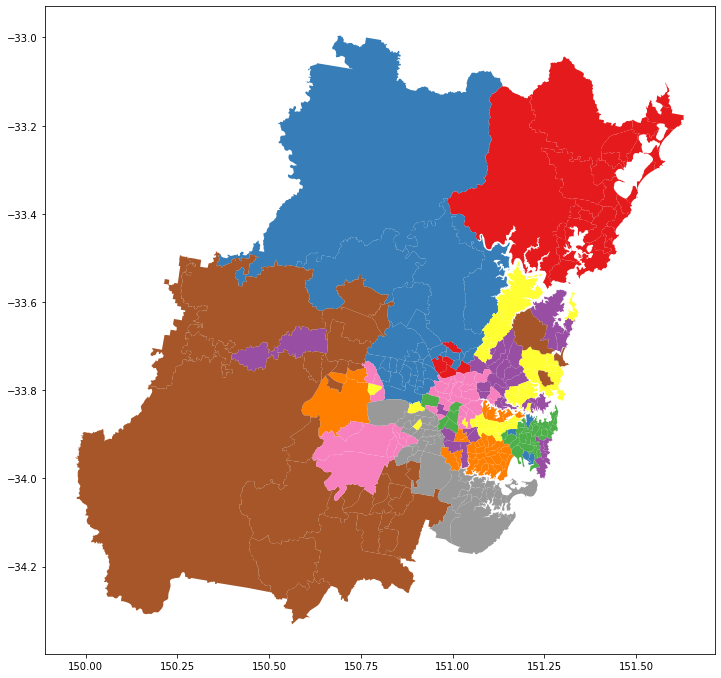

In [126]:
sa2_map = gpd.read_postgis("SELECT ST_Transform(geom,4326) As location FROM sa2_shape_data", conn, geom_col='location')
sa2_map.plot(cmap='Set1',figsize=(12,12),legend = True)

<AxesSubplot:>

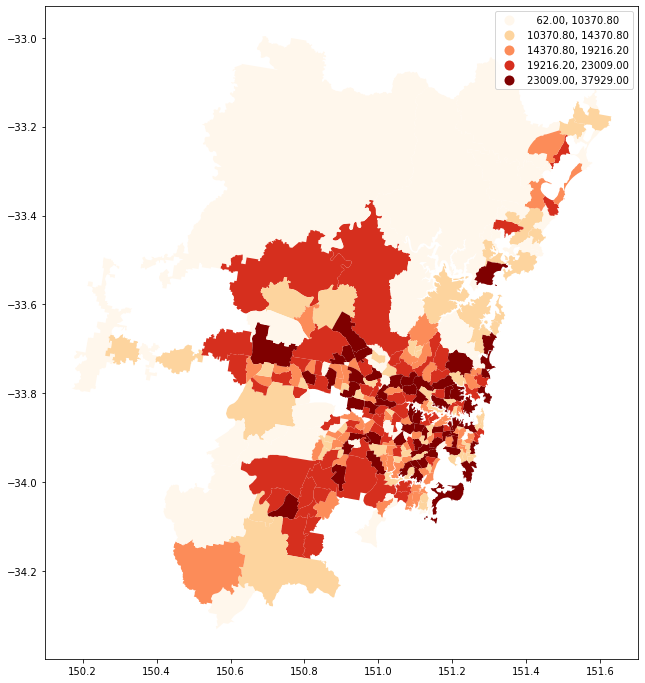

In [127]:
narea= gpd.read_postgis("SELECT*FROM neighbourhoods", conn, geom_col= 'geom')
narea.plot(cmap='OrRd',figsize=(12,12),column = 'population', scheme= 'quantiles', legend = True)

<AxesSubplot:>

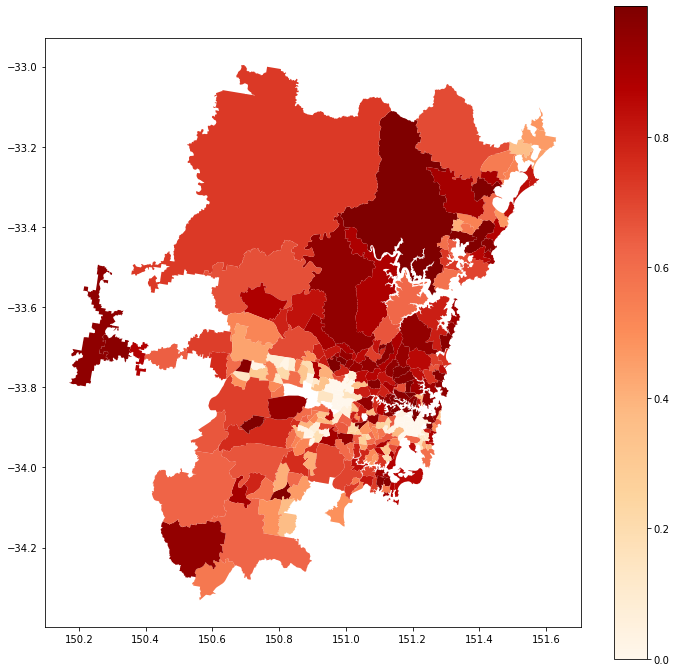

In [128]:
s_area = gpd.read_postgis("SELECT*FROM score",conn,geom_col='geom')
s_area.plot(cmap='OrRd',figsize=(12,12),column='liveability_score',legend=True)

## correlation

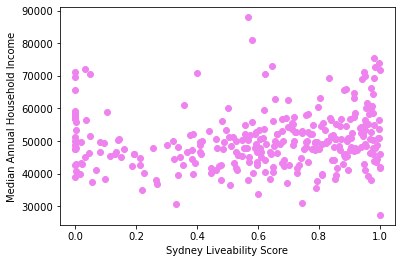

In [129]:
plt.scatter(score_final['liveability_score'],score_final['median_annual_household_income'],color = 'violet')
plt.xlabel('Sydney Liveability Score')
plt.ylabel('Median Annual Household Income')
plt.show()

In [130]:
corr,_ =pearsonr(score_final['liveability_score'],score_final['median_annual_household_income'])
print('Pearsons correlation: %.3f' %corr)

Pearsons correlation: 0.126


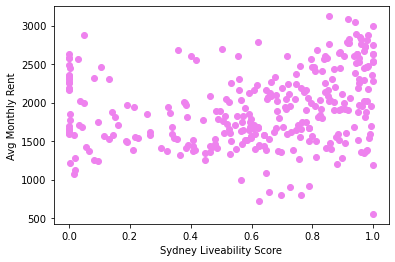

In [131]:
plt.scatter(score_final['liveability_score'],score_final['avg_monthly_rent'],color = 'violet')
plt.xlabel('Sydney Liveability Score')
plt.ylabel('Avg Monthly Rent')
plt.show()

In [132]:
corr,_ =pearsonr(score_final['liveability_score'],score_final['avg_monthly_rent'])
print('Pearsons correlation: %.3f' %corr)

Pearsons correlation: 0.230


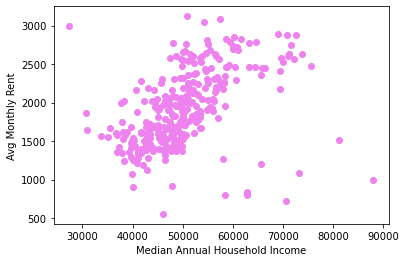

In [133]:
plt.scatter(score_final['median_annual_household_income'],score_final['avg_monthly_rent'],color = 'violet')
plt.xlabel('Median Annual Household Income')
plt.ylabel('Avg Monthly Rent')
plt.show()

In [134]:
corr,_ =pearsonr(score_final['median_annual_household_income'],score_final['avg_monthly_rent'])
print('Pearsons correlation: %.3f' %corr)

Pearsons correlation: 0.452


# Task3

## Import datasets from City of Sydney Open Data Hub into pgadmin

In [135]:
data_path = "C:/Users/admin/2001group"
new_data = gpd.read_file( os.path.join(data_path, "Greenhouse_gas_emissions_profile_by_suburb.geojson") )
new_data = new_data.dropna()
new_data

,OBJECTID1,Area_suburb,Data_Category,F2005_06,F2006_07,F2007_08,F2008_09,F2009_10,F2010_11,F2011_12,F2012_13,F2013_14,F2014_15,F2015_16,F2016_17,F2017_18,F2018_19,Shape__Area,Shape__Length,geometry
0,1,Newtown + St Peters,Electricity (Disaggregated),68244.718530,68908.392480,54931.528310,54068.546750,54696.062360,55336.992390,53578.532090,53180.756560,51178.372610,46997.936240,45562.361100,40245.232030,39443.476050,37247.541290,1.427271e+06,8815.394724,"MULTIPOLYGON (((151.18571 -33.91744, 151.18556..."
1,2,Newtown + St Peters,Gas (Disaggregated),4635.031427,4636.506642,4343.603477,4310.464360,4305.069269,4054.575075,4053.222270,4092.708623,4073.800698,4273.516941,4406.080005,4318.561195,4191.225421,4046.531387,1.427271e+06,8815.394724,"MULTIPOLYGON (((151.18571 -33.91744, 151.18556..."
3,4,Newtown + St Peters,Transport (Disaggregated),8609.342071,8880.381799,8916.245395,8732.361737,8972.860364,9209.887700,8791.414528,9022.290556,9022.449782,9151.670418,8750.953004,10488.231170,10486.749220,10960.795700,1.427271e+06,8815.394724,"MULTIPOLYGON (((151.18571 -33.91744, 151.18556..."
4,5,Newtown + St Peters,Waste (Disaggregated),16739.906110,16958.748330,17003.488460,15577.258490,10278.727450,9913.244498,9747.702366,9589.026543,9599.323701,9659.897765,9740.801720,10817.907280,10546.415360,11577.239900,1.427271e+06,8815.394724,"MULTIPOLYGON (((151.18571 -33.91744, 151.18556..."
6,7,Alexandria,Electricity (Disaggregated),188840.778900,190536.110800,191218.779800,174280.306400,165054.983800,173738.272600,172959.100800,164401.930600,154240.152000,146059.267900,141261.611600,141582.133100,140058.409800,132330.614900,5.129712e+06,12267.960764,"POLYGON ((151.19913 -33.89517, 151.19913 -33.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,167,Forest Lodge + Annandale,Waste (Disaggregated),10861.070640,10979.000220,9328.137168,6981.080044,3623.707026,2511.789269,1471.177223,1396.497484,1380.571942,1383.823982,1388.321750,1567.333869,3676.370546,4788.847051,7.939478e+05,6817.416670,"POLYGON ((151.17727 -33.87272, 151.17728 -33.8..."
168,169,The Rocks,Electricity (Disaggregated),121442.660300,122577.262100,120723.744800,116301.241800,119699.307600,115412.987100,107888.946200,106142.819400,102792.084000,91074.142290,86775.779750,83542.045000,81112.191450,76694.135910,3.091627e+05,3549.527779,"POLYGON ((151.20980 -33.86103, 151.20980 -33.8..."
169,170,The Rocks,Gas (Disaggregated),5557.482976,5612.514499,5338.750196,5424.492633,5625.262771,5495.896049,5591.664983,5576.656414,5472.615537,5689.562608,5673.554913,5342.778192,5004.379575,4588.940152,3.091627e+05,3549.527779,"POLYGON ((151.20980 -33.86103, 151.20980 -33.8..."
171,172,The Rocks,Transport (Disaggregated),9565.122626,9777.305671,9724.120633,9535.671769,9596.136562,9657.959429,9682.341263,9775.830080,9818.188911,9934.545258,9774.152640,10094.815150,10343.169230,10622.283900,3.091627e+05,3549.527779,"POLYGON ((151.20980 -33.86103, 151.20980 -33.8..."


In [136]:
conn.execute("DROP TABLE IF EXISTS greenhouse")

g_shcema = """CREATE TABLE IF NOT EXISTS greenhouse (
                              OBJECTID1        INTEGER, 
                              Area_suburb      TEXT, 
                              Data_Category    TEXT, 
                              F2005_06         INTEGER, 
                              F2006_07         INTEGER, 
                              F2007_08         INTEGER, 
                              F2008_09         INTEGER, 
                              F2009_10         INTEGER, 
                              F2010_11         INTEGER, 
                              F2011_12         INTEGER, 
                              F2012_13         INTEGER, 
                              F2013_14         INTEGER, 
                              F2014_15         INTEGER,
                              F2015_16         INTEGER,
                              F2016_17         INTEGER,
                              F2017_18         INTEGER,
                              F2018_19         INTEGER,
                              Shape__Area      INTEGER,
                              Shape__Length    INTEGER, 
                              geom             GEOMETRY(MULTIPOLYGON,4283)
                              )"""


conn.execute(g_shcema)


newg_copy = new_data.copy()
newg_copy.columns = newg_copy.columns.map(lambda x:x. lower())
newg_copy['geom'] = newg_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
newg_copy = newg_copy.drop(columns="geometry")

newg_copy.to_sql('greenhouse', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

test_new = pd.read_sql_query('SELECT * FROM "greenhouse"', conn)
test_new

,objectid1,area_suburb,data_category,f2005_06,f2006_07,f2007_08,f2008_09,f2009_10,f2010_11,f2011_12,f2012_13,f2013_14,f2014_15,f2015_16,f2016_17,f2017_18,f2018_19,shape__area,shape__length,geom
0,1,Newtown + St Peters,Electricity (Disaggregated),68245,68908,54932,54069,54696,55337,53579,53181,51178,46998,45562,40245,39443,37248,1427271,8815,0106000020BB1000000200000001030000000100000052...
1,19,Chippendale,Electricity (Disaggregated),41543,42016,42574,43125,44039,44577,43732,48379,51421,51181,51441,51784,51790,51592,669425,3815,0106000020BB1000000100000001030000000100000056...
2,2,Newtown + St Peters,Gas (Disaggregated),4635,4637,4344,4310,4305,4055,4053,4093,4074,4274,4406,4319,4191,4047,1427271,8815,0106000020BB1000000200000001030000000100000052...
3,20,Chippendale,Gas (Disaggregated),2930,2947,2814,2856,2903,2784,2835,2895,2902,3081,3228,3484,4910,5895,669425,3815,0106000020BB1000000100000001030000000100000056...
4,4,Newtown + St Peters,Transport (Disaggregated),8609,8880,8916,8732,8973,9210,8791,9022,9022,9152,8751,10488,10487,10961,1427271,8815,0106000020BB1000000200000001030000000100000052...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,170,The Rocks,Gas (Disaggregated),5557,5613,5339,5424,5625,5496,5592,5577,5473,5690,5674,5343,5004,4589,309163,3550,0106000020BB1000000100000001030000000100000007...
112,172,The Rocks,Transport (Disaggregated),9565,9777,9724,9536,9596,9658,9682,9776,9818,9935,9774,10095,10343,10622,309163,3550,0106000020BB1000000100000001030000000100000007...
113,173,The Rocks,Waste (Disaggregated),17797,17964,18140,16348,10679,10710,10789,10835,10930,11033,11168,12310,9301,9839,309163,3550,0106000020BB1000000100000001030000000100000007...
114,155,Potts Point,Waste (Disaggregated),19494,19767,20269,18989,12795,12602,12659,12495,12539,12648,12782,14232,14395,16966,870986,6898,0106000020BB100000010000000103000000010000001B...


## Refine liveability score

## Add a new property and import it into pgadmin

In [137]:
gas = pd.read_sql_query("""select area_id,sum(g.shape__area)/per_young as gas
from "neighbourhoods" N join "greenhouse" g on ST_Intersects(N.geom,g.geom) 
group by area_id,per_young
ORDER BY area_id;
""", conn)
score_new = pd.merge(test,gas,how='left',on = 'area_id')
score_new['gas'].fillna(0,inplace= True)
gas_mean = score_new['gas'].mean()
gas_std = score_new['gas'].std()
for index,row in score_new.iterrows():
    score_new.at[index,'z_gas'] = (row['gas']-gas_mean) /gas_std
score_new = score_new.drop(columns='gas')
score_new

,area_id,area_name,geom,median_annual_household_income,avg_monthly_rent,z_school,z_accom,z_retail,z_crime,z_health,liveability_score,z_gas
0,102011028,Avoca Beach - Copacabana,0106000020BB100000010000000103000000010000005E...,46996.0,1906.0,-0.072051,0.140544,-0.263253,-2.234913,0.361358,0.916942,-0.183684
1,102011029,Box Head - MacMasters Beach,0106000020BB1000000100000001030000000100000000...,42621.0,1682.0,-0.072051,-0.472598,-0.361426,-2.231021,-0.468103,0.702001,-0.183684
2,102011030,Calga - Kulnura,0106000020BB1000000200000001030000000100000085...,42105.0,1182.0,17.348172,-0.255441,0.550609,-2.234913,-0.766389,1.000000,-0.183684
3,102011031,Erina - Green Point,0106000020BB1000000100000001030000000100000041...,43481.0,1595.0,-0.072051,0.257083,0.798755,-2.232876,1.331450,0.989524,-0.183684
4,102011032,Gosford - Springfield,0106000020BB100000010000000103000000010000007F...,45972.0,1382.0,-0.072051,0.276890,0.499627,-1.730382,1.355839,0.977919,-0.183684
...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,0106000020BB10000001000000010300000001000000EF...,55391.0,1947.0,-0.072051,-0.401588,-0.417154,-2.205398,-0.415763,0.710711,-0.183684
305,128021538,Sutherland - Kirrawee,0106000020BB1000000100000001030000000100000089...,53378.0,1809.0,0.071367,-0.129558,-0.152413,-1.795309,-0.068588,0.819966,-0.183684
306,128021607,Engadine,0106000020BB100000010000000103000000010000008E...,52667.0,1955.0,-0.072051,-0.464456,-0.387353,-2.204603,-0.303486,0.726564,-0.183684
307,128021608,Loftus - Yarrawarrah,0106000020BB10000001000000010300000001000000A1...,51243.0,2163.0,-0.072051,-0.712391,-0.628744,-2.234913,-0.581894,0.559672,-0.183684


In [138]:
for index,row in score_new.iterrows():
    score_new.at[index,'new_liveability_score'] = sigmoid(row['z_school']+row['z_accom']+row['z_retail']-row['z_crime']+row['z_health']-row['z_gas'])
score_new

,area_id,area_name,geom,median_annual_household_income,avg_monthly_rent,z_school,z_accom,z_retail,z_crime,z_health,liveability_score,z_gas,new_liveability_score
0,102011028,Avoca Beach - Copacabana,0106000020BB100000010000000103000000010000005E...,46996.0,1906.0,-0.072051,0.140544,-0.263253,-2.234913,0.361358,0.916942,-0.183684,0.929903
1,102011029,Box Head - MacMasters Beach,0106000020BB1000000100000001030000000100000000...,42621.0,1682.0,-0.072051,-0.472598,-0.361426,-2.231021,-0.468103,0.702001,-0.183684,0.738952
2,102011030,Calga - Kulnura,0106000020BB1000000200000001030000000100000085...,42105.0,1182.0,17.348172,-0.255441,0.550609,-2.234913,-0.766389,1.000000,-0.183684,1.000000
3,102011031,Erina - Green Point,0106000020BB1000000100000001030000000100000041...,43481.0,1595.0,-0.072051,0.257083,0.798755,-2.232876,1.331450,0.989524,-0.183684,0.991266
4,102011032,Gosford - Springfield,0106000020BB100000010000000103000000010000007F...,45972.0,1382.0,-0.072051,0.276890,0.499627,-1.730382,1.355839,0.977919,-0.183684,0.981555
...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,0106000020BB10000001000000010300000001000000EF...,55391.0,1947.0,-0.072051,-0.401588,-0.417154,-2.205398,-0.415763,0.710711,-0.183684,0.746972
305,128021538,Sutherland - Kirrawee,0106000020BB1000000100000001030000000100000089...,53378.0,1809.0,0.071367,-0.129558,-0.152413,-1.795309,-0.068588,0.819966,-0.183684,0.845509
306,128021607,Engadine,0106000020BB100000010000000103000000010000008E...,52667.0,1955.0,-0.072051,-0.464456,-0.387353,-2.204603,-0.303486,0.726564,-0.183684,0.761504
307,128021608,Loftus - Yarrawarrah,0106000020BB10000001000000010300000001000000A1...,51243.0,2163.0,-0.072051,-0.712391,-0.628744,-2.234913,-0.581894,0.559672,-0.183684,0.604324


In [139]:
conn.execute("DROP TABLE IF EXISTS new_score")

score_scheme = """ CREATE TABLE new_score(
                                area_id                          INTEGER,
                                area_name                        TEXT,
                                geom                             GEOMETRY(MULTIPOLYGON,4283),
                                median_annual_household_income   FLOAT,
                                avg_monthly_rent                 FLOAT,
                                z_school                         FLOAT,
                                z_accom                          FLOAT,
                                z_retail                         FLOAT,
                                z_crime                          FLOAT,
                                z_health                         FLOAT,
                                liveability_score                FLOAT,
                                z_gas                            FLOAT,
                                new_liveability_score            FLOAT)"""
conn.execute(score_scheme)

table_name = "new_score"
score_new.to_sql(table_name,conn,if_exists='append',index = False,dtype = {'geom': Geometry('MULTIPOLYGON',srid)})

test = pd.read_sql_query('SELECT * FROM new_score',conn)
test

,area_id,area_name,geom,median_annual_household_income,avg_monthly_rent,z_school,z_accom,z_retail,z_crime,z_health,liveability_score,z_gas,new_liveability_score
0,102011028,Avoca Beach - Copacabana,0106000020BB100000010000000103000000010000005E...,46996.0,1906.0,-0.072051,0.140544,-0.263253,-2.234913,0.361358,0.916942,-0.183684,0.929903
1,102011029,Box Head - MacMasters Beach,0106000020BB1000000100000001030000000100000000...,42621.0,1682.0,-0.072051,-0.472598,-0.361426,-2.231021,-0.468103,0.702001,-0.183684,0.738952
2,102011030,Calga - Kulnura,0106000020BB1000000200000001030000000100000085...,42105.0,1182.0,17.348172,-0.255441,0.550609,-2.234913,-0.766389,1.000000,-0.183684,1.000000
3,102011031,Erina - Green Point,0106000020BB1000000100000001030000000100000041...,43481.0,1595.0,-0.072051,0.257083,0.798755,-2.232876,1.331450,0.989524,-0.183684,0.991266
4,102011032,Gosford - Springfield,0106000020BB100000010000000103000000010000007F...,45972.0,1382.0,-0.072051,0.276890,0.499627,-1.730382,1.355839,0.977919,-0.183684,0.981555
...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,0106000020BB10000001000000010300000001000000EF...,55391.0,1947.0,-0.072051,-0.401588,-0.417154,-2.205398,-0.415763,0.710711,-0.183684,0.746972
305,128021538,Sutherland - Kirrawee,0106000020BB1000000100000001030000000100000089...,53378.0,1809.0,0.071367,-0.129558,-0.152413,-1.795309,-0.068588,0.819966,-0.183684,0.845509
306,128021607,Engadine,0106000020BB100000010000000103000000010000008E...,52667.0,1955.0,-0.072051,-0.464456,-0.387353,-2.204603,-0.303486,0.726564,-0.183684,0.761504
307,128021608,Loftus - Yarrawarrah,0106000020BB10000001000000010300000001000000A1...,51243.0,2163.0,-0.072051,-0.712391,-0.628744,-2.234913,-0.581894,0.559672,-0.183684,0.604324


## Visualise

<AxesSubplot:>

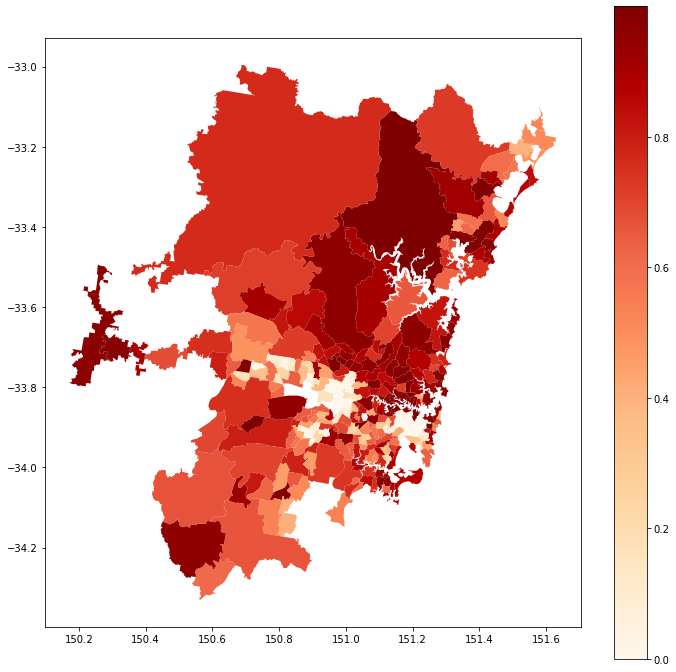

In [140]:
s_area = gpd.read_postgis("SELECT*FROM new_score",conn,geom_col='geom')
s_area.plot(cmap='OrRd',figsize=(12,12),column='new_liveability_score',legend=True)

# Disconnect

In [ ]:
conn.close()
db.dispose()